<a href="https://colab.research.google.com/github/soline013/Machine-Learning-ML/blob/master/Transformer/TorchText%2C_Multi30k%2C_pytorch%EB%A1%9C_transformer_%ED%95%99%EC%8A%B5%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing
Pytorch와 torchtext를 이용하여 Preprocessing을 진행한다.

Dataset은 Multi30k, Tokenization은 spaCy를 이용한다.



In [5]:
!pip install --upgrade torchtext
!pip freeze | grep torch
import torch
import torchtext

Requirement already up-to-date: torchtext in /usr/local/lib/python3.6/dist-packages (0.8.1)
torch==1.7.1
torchsummary==1.5.1
torchtext==0.8.1
torchvision==0.8.1+cu101


In [6]:
!pip install spacy
!python -m spacy download de
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [7]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator, interleave_keys

def itos(field, batch):
    """
    spaCy는 detokenizing이 불가능한 구조 입니다.
    production, 본격적인 논문 구현을 하실 경우, huggingface tokenizer나 google sentencepiece를 사용하셔야합니다.
    이번 프로젝트에서는 detokenizing을 하지 않고, token의 값만 확인해봅시다.
    """
    '''
    Tokenization Reference: https://wikidocs.net/21698
                            https://excelsior-cjh.tistory.com/63
    Detokenization Reference: https://kh-kim.gitbooks.io/pytorch-natural-language-understanding/content/preprocessing/detokenization.html
    '''
    with torch.cuda.device_of(batch):
        batch = batch.T.tolist()#. Before Change.
        #batch = batch.tolist()
    batch = [[field.vocab.itos[ind] for ind in ex] for ex in batch]  # denumericalize

    def trim(s, t):
        sentence = []
        for w in s:
            if w == t:
                break
            sentence.append(w)
        return sentence

    batch = [trim(ex, field.eos_token) for ex in batch]  # trim past frst eos

    def filter_special(tok):
        return tok not in (field.init_token, field.pad_token)

    batch = [list(filter(filter_special, ex)) for ex in batch]
    return batch

'''
torchtext.data.Field: Defines a datatype together with instructions for converting to Tensor.
                      즉, 데이터가 어떻게 처리될지 지정.
torchtext.data.Batch: Defines a batch of examples along with its Fields.
'''
SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True) #lower는 소문자에 대한 Parameter.

TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

# Field, build vocab, batch 로직이 궁금하다면, 아래 레퍼런스를 확인하시면 됩니다.
# Field: https://pytorch.org/text/stable/_modules/torchtext/data/field.html
# Tokenizer 선택 과정: https://pytorch.org/text/_modules/torchtext/data/utils.html
# Batch: https://pytorch.org/text/stable/_modules/torchtext/data/batch.html
# Iterator: https://pytorch.org/text/stable/_modules/torchtext/data/iterator.html#Iterator

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for fur

In [8]:
# special token 확인하기
(
    'SRC',
    SRC.init_token, SRC.eos_token, SRC.pad_token,
    'TRG',
    TRG.init_token, TRG.eos_token, TRG.pad_token,
)

('SRC', '<sos>', '<eos>', '<pad>', 'TRG', '<sos>', '<eos>', '<pad>')

In [9]:
#Build the vocabularies.
SRC.build_vocab(train_data)
TRG.build_vocab(train_data)

In [10]:
'''
torchtext.data.BucketIterator: 데이터 공급기(Iterator)를 만들 수 있는데,
                               Batch를 받을 때 Source Sentences가 모두 같은 크기를 갖도록 Padding 과정이 필요하다.
                               BucketIterator는 Padding 수를 최소화하여 Padding 할 수 있도록 한다.
'''
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
import numpy as np
from torch.autograd import Variable

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=1):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2) # source mask, <pad>: False, other tokens: True
        if trg is not None:
            # target sentence 0 ~ -1
            # > 마지막 단어는 디코더의 입력으로 넣지 않음
            self.trg = trg[:, :-1]#. Before Change.
            #self.trg = trg.T[:, :-1]

            # target sentence 1 ~ end
            # > 디코더의 결과값의 ground truth
            self.trg_y = trg[:, 1:]#. Before Change.
            #self.trg_y = trg.T[:, :-1]

            self.trg_mask = \
                self.make_std_mask(self.trg, pad) # target mask
            self.ntokens = (self.trg_y != pad).data.sum() # number of tokens
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask


def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    # https://nlp.seas.harvard.edu/2018/04/03/attention.html 의 run_epoch 에 L42을 추가한 버전.
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    pad_index = SRC.vocab[SRC.pad_token] # <pad> 를 index 인 1 로 변환시키기.

    for i, batch_without_mask in enumerate(data_iter):
        # mask 적용하기.
        batch = Batch(batch_without_mask.src, batch_without_mask.trg, pad_index) # torchtext를 사용해서 이미 iterator가 선언되어버림. 그래서 여기서 마스크를 적용해준다.

        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [12]:
# 데이터 확인해보기.
for batch_without_mask in train_iterator:
    batch = Batch(batch_without_mask.src, batch_without_mask.trg)
    print(batch.src.shape, batch.src_mask.shape, batch.trg.shape, batch.trg_mask.shape)
    print(batch.src, batch.src_mask, batch.trg, batch.trg_mask)
    print(itos(TRG, batch.trg))
    print(itos(SRC, batch.src))
    
    break

torch.Size([26, 128]) torch.Size([26, 1, 128]) torch.Size([26, 127]) torch.Size([26, 127, 127])
tensor([[    2,     2,     2,  ...,     2,     2,     2],
        [    5,    18,     5,  ...,     5,     5,     5],
        [11128,    30,    13,  ...,  1880,   673,    13],
        ...,
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1]]) tensor([[[ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True]],

        ...,

        [[False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False]]]) tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,   16,    4,  ...,    7,    4,    4],
        [ 192, 1397,    9,  ...,   35,   39,   64],
      

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Transformer
Harvard NLP의 코드를 참고하여 Transformer를 구현한다.

## Prelims

In [13]:
#!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn
seaborn.set_context(context="talk")

## Model Architecture

In [15]:
'''
EncoderDecoder() Using Example.
EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, trg_vocab), c(position)),
        Generator(d_model, trg_vocab))
'''
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.trg_embed(trg), memory, src_mask, trg_mask)
        return output

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, trg, trg_mask):
        return self.decoder(self.trg_embed(trg), memory, src_mask, trg_mask)    

In [16]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) #Convert Vectors to Words.

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

### Encoder

In [17]:
'''
For Stack Encoder & Decoder.
The encoder is composed of a stack of N=6 identical layers.
'''
def clones(module, N):
    "Produce N identical layers."
    #It seems to copy operation.
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [18]:
'''
Encoder() Using Example.
Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
'''
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) #Clones.
        self.norm = LayerNorm(layer.size) #Layer Normalization.
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

$$\bar{x} = \frac{a}{\sigma}(x - \mu) + b$$

In [19]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features)) #Ones.
        self.b_2 = nn.Parameter(torch.zeros(features)) #Zeros.
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) #Mean Operation.
        std = x.std(-1, keepdim=True) #Standard Deviation(표준편차) Operation.
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2 #a/σ * (x - μ) + b. Layer Normalization Operation.

In [20]:
'''
1. Sub-layer.

2.. Add & Norm Part.
x + Sublayer(x) is Add.
LayerNorm() is Norm.

3. Residual Connection.
'''
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size) #Layer Normalization.
        self.dropout = nn.Dropout(dropout) #Dropout.

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x))) #LayerNorm(x + Sublayer(x))

In [21]:
'''
Encoder has two sublayers, Self-attention and Feed Forward.

EncoderLayer() Using Example.
EncoderLayer(d_model, c(attn), c(ff), dropout)
'''
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn #Multi Head Self Attention.
        self.feed_forward = feed_forward #Position-wise Feed Forward.
        self.sublayer = clones(SublayerConnection(size, dropout), 2) #Add & Norm and Residual Connection.
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."

        #Sub-layer 1.
        #Apply Add & Norm and Residual Connection to Self-attention.
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))

        #Sub-layer 2.
        #Apply Add & Norm and Residual Connection to Feed Forward.
        return self.sublayer[1](x, self.feed_forward)

### Decoder

In [22]:
'''
Decoder() Using Example.
Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N)
'''
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N) #Clones(defined above).
        self.norm = LayerNorm(layer.size) #defined Layer Normalization(defined above).
        
    #More Mask.
    def forward(self, x, memory, src_mask, trg_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, trg_mask) #Memory is encoder's output.
        return self.norm(x)

In [23]:
'''
Encoder has three sublayers, Self-attention, Encoder-Decoder Attention and Feed Forward.
Encoder-Decoder Attention is not Self-attention.

DecoderLayer() Using Example.
DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
'''
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn #Multi Head Self Attention.
        self.src_attn = src_attn #Encoder-Decoder Multi Head Attention(Not Self).
        self.feed_forward = feed_forward #Position-wise Feed Forward.
        self.sublayer = clones(SublayerConnection(size, dropout), 3) #Add & Norm and Residual Connection.
 
    #More Mask.
    def forward(self, x, memory, src_mask, trg_mask):
        "Follow Figure 1 (right) for connections."
        m = memory

        #Apply Add & Norm and Residual Connection to Self-attention.
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, trg_mask))

        #Apply Add & Norm and Residual Connection to Encoder-Decoder Aattention.
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))

        #Apply Add & Norm and Residual Connection to Feed Forward.
        return self.sublayer[2](x, self.feed_forward)

[(cite)](https://www.quantumdl.com/entry/11%EC%A3%BC%EC%B0%A82-Attention-is-All-You-Need-Transformer)

> 또한 Decoder의 Sub-Layer에서 사용하는 Self-Attention방식을 조금 변경할 것이다. 이는 ByteNet에서 사용했던 방식을 생각하면 이해하기 용이한데, 해당 position에 대해 Attention을 계산하기 위한 부분에서 해당 position의 time step보다 앞선 Attention을 막아줄 것이다. (사실 t에 대한 Attention을 계산하기 위해 t+1의 정보를 가져다 쓰는 것은 좋은 구성이 아니라는 사실을 쉽게 알 수 있다.) -> Cheating.

In [24]:
'''
When time step is t, we should apply mask t+1 positions.
'''
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') #np.triu(): Including bacd_id, Upper Part Copy. 
    return torch.from_numpy(subsequent_mask) == 0 #True: Diagonal line Bottom. False: Diagonal line Top.

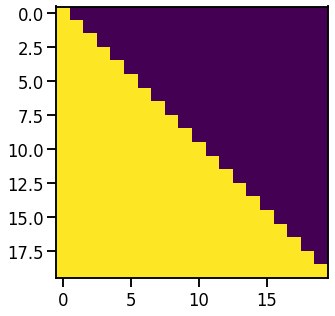

In [25]:
# The attention mask shows the position each trg word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training. 
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

### Attention

$$Attention(Q, K, V) = softmax(\frac{Q \times K^T}{\sqrt{d_k}})V$$

In [26]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1) #Query Size = (length, d_k).
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k) #Q*K^T / d_k^{1/2}. Scores Size = (length, length).
    if mask is not None:
        # > 마스크가 False(=0)인 점은 -10^9 로 채워 학습되는 것을 방지
        scores = scores.masked_fill(mask == 0, -1e9) #Masking.
    p_attn = F.softmax(scores, dim = -1) #Softmax. p_attn Size = (length, d_k).

    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout) #Dropput.
    return torch.matmul(p_attn, value), p_attn #Matmul p_aatn and V. Return Size = (length, d_k).

### Multi-Head Attention

[(cite)](https://www.quantumdl.com/entry/11%EC%A3%BC%EC%B0%A82-Attention-is-All-You-Need-Transformer)

> Multi-head Attention에서는 query, key, value를 바로 사용하는 것이 아닌 h번(h = 8)의 Linear projection을 따라 서로 다른 representation의 조합으로부터 Attention을 계산하는 방법이다. 이러한 방법은 이전 논문인 Bidirectional Attention Flow(BiDAF)에서도 사용되는 방법인 것을 생각해보면 생각보다 이해하기 용이하다.

> 사실 여기서 8번의 연산만큼 계산 비용도 8배로 늘어날 것으로 이해하기 쉬운데, Linear projection단계에서 차원을 줄여주게 되므로 연산량 자체는 비슷하게 되는 것이 특징이다.

In [27]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 #Check.
        # We assume d_v always equals d_k
        self.d_k = d_model // h #d_k. We need integer.
        self.h = h #h(Repeat Times).
        self.dropout = dropout #Dropout.
        self.linears = clones(nn.Linear(d_model, d_model), 4) #Clones. Four Linear Modules are needed.
        self.attn = None #Attention.
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1) #Head part of mask vector is 1.
        nbatches = query.size(0) #Query Size: (nbatches, length, d_model).
        
        #Linear Projections.
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # > 1) Q, K, V 에 linear projection을 취한 후 사이즈 변환 => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))] #Size: (nbatches, h, length, d_k).
        
        #Apply Attention.
        # 2) Apply attention on all the projected vectors in batch.
        # > 2) (length, d_k) 사이즈의 벡터들에 attention을 h번 적용
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout) #X Size: (nbatches, h, length, d_k).
        
        #Concat & Linear.
        # 3) "Concat" using a view and apply a final linear. 
        # > x를 이어붙인 후 마지막 linear projection 적용
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) #Size: (nbatches, length, d_model).
'''
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
'''

'\nclass MultiHeadedAttention(nn.Module):\n    def __init__(self, h, d_model, dropout=0.1):\n        "Take in model size and number of heads."\n        super(MultiHeadedAttention, self).__init__()\n        assert d_model % h == 0\n        # We assume d_v always equals d_k\n        self.d_k = d_model // h\n        self.h = h\n        self.linears = clones(nn.Linear(d_model, d_model), 4)\n        self.attn = None\n        self.dropout = nn.Dropout(p=dropout)\n        \n    def forward(self, query, key, value, mask=None):\n        "Implements Figure 2"\n        if mask is not None:\n            # Same mask applied to all h heads.\n            mask = mask.unsqueeze(1)\n        nbatches = query.size(0)\n        \n        # 1) Do all the linear projections in batch from d_model => h x d_k \n        query, key, value =             [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)\n             for l, x in zip(self.linears, (query, key, value))]\n        \n        # 2) Apply attention

### Position-wise Feed-Forward Networks

$$FFN(x) = max(0, xW_1 b_1) W_2 + b_2$$

In [28]:
'''
1. d_modek is embedding to d_ff.
2. Apply ReLU Function.
3. d_ff is embedding to d_model.
'''
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff) #nn.Linear.
        self.w_2 = nn.Linear(d_ff, d_model) #nn.Linear.
        self.dropout = nn.Dropout(dropout) #Dropout.

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x)))) #max(0, xw_1)w_2. (+Dropout)

### Embeddings and Softmax

[(cite)](https://www.quantumdl.com/entry/11%EC%A3%BC%EC%B0%A82-Attention-is-All-You-Need-Transformer)

> Transformer에서는 각 Embedding Layer와 softmax전 적용하는 각 Linear transformation의 weight를 공유해서 학습한다. 즉, 고정된 Embedding을 사용하는 것이 아니라 Embedding weight도 계속 학습하게 된다. (다만 Embedding Layer에서는 weight를 √(d_model)만큼 곱해준다.)

In [29]:
'''
d_model: Input & Output Dimension of All Layer, Transfomer's Hyperparameter.
         In paper, d_model has 512.
'''
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model) #Embedding.
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) #Weight * d_model^{1/2}.

### Positional Encoding

$$PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}}) \\ PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})$$

In [30]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model) #Zeros.
        position = torch.arange(0, max_len).unsqueeze(1) #pos. (max_len, 1).
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model)) #1 / 10000^{2i / d_model}.
        pe[:, 0::2] = torch.sin(position * div_term) #sin(pos / 10000^{2i / d_model}).
        pe[:, 1::2] = torch.cos(position * div_term) #cos(pos / 10000^{2i / d_model}).
        pe = pe.unsqueeze(0) #(1, max_len, d_model).
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False) #Until x's length.
        return self.dropout(x) #Dropout.

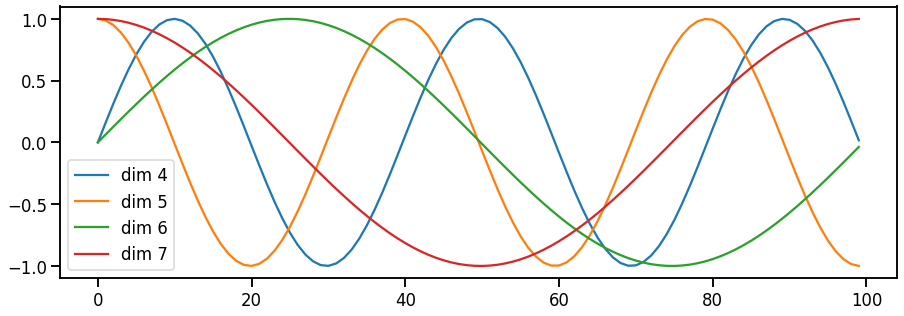

In [31]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

### Full Model

In [32]:
def make_model(src_vocab, trg_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy #Copy. (Using colnes().)
    attn = MultiHeadedAttention(h, d_model, dropout) #Multi Head Self Attention.
    ff = PositionwiseFeedForward(d_model, d_ff, dropout) #Position-wise Feed Forward.
    position = PositionalEncoding(d_model, dropout) #Positional Encoding.
    model = EncoderDecoder( #EncoderDecoder.
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N), #Encoder & EncoderLayer.
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N), #Decoder & DecoderLayer.
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)), #Embeddings SRC.
        nn.Sequential(Embeddings(d_model, trg_vocab), c(position)), #Embeddings TRG.
        Generator(d_model, trg_vocab)) #Generator.
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [33]:
# Small example model.
tmp_model = make_model(10, 10, 2)
tmp_model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=Fals

## Training

### Batches and Masking (Not Use)

In [34]:
'''
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(trg, pad):
        "Create a mask to hide padding and future words."
        trg_mask = (trg != pad).unsqueeze(-2)
        trg_mask = trg_mask & Variable(
            subsequent_mask(trg.size(-1)).type_as(trg_mask.data))
        return trg_mask
'''

'\nclass Batch:\n    "Object for holding a batch of data with mask during training."\n    def __init__(self, src, trg=None, pad=0):\n        self.src = src\n        self.src_mask = (src != pad).unsqueeze(-2)\n        if trg is not None:\n            self.trg = trg[:, :-1]\n            self.trg_y = trg[:, 1:]\n            self.trg_mask =                 self.make_std_mask(self.trg, pad)\n            self.ntokens = (self.trg_y != pad).data.sum()\n    \n    @staticmethod\n    def make_std_mask(trg, pad):\n        "Create a mask to hide padding and future words."\n        trg_mask = (trg != pad).unsqueeze(-2)\n        trg_mask = trg_mask & Variable(\n            subsequent_mask(trg.size(-1)).type_as(trg_mask.data))\n        return trg_mask\n'

### Training Loop (Not Use)

In [35]:
'''
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens
'''

'\ndef run_epoch(data_iter, model, loss_compute):\n    "Standard Training and Logging Function"\n    start = time.time()\n    total_tokens = 0\n    total_loss = 0\n    tokens = 0\n    for i, batch in enumerate(data_iter):\n        out = model.forward(batch.src, batch.trg, \n                            batch.src_mask, batch.trg_mask)\n        loss = loss_compute(out, batch.trg_y, batch.ntokens)\n        total_loss += loss\n        total_tokens += batch.ntokens\n        tokens += batch.ntokens\n        if i % 50 == 1:\n            elapsed = time.time() - start\n            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %\n                    (i, loss / batch.ntokens, tokens / elapsed))\n            start = time.time()\n            tokens = 0\n    return total_loss / total_tokens\n'

### Training Data and Batching

In [36]:
global max_src_in_batch, max_trg_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_trg_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_trg_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_trg_in_batch = max(max_trg_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    trg_elements = count * max_trg_in_batch
    return max(src_elements, trg_elements)

### Optimizer

In [37]:
'''
Warm-up: ~4000 Step. Increase the low LR to the high LR.
Like Fine-tuning: Decrease the high LR to the low LR.
'''
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

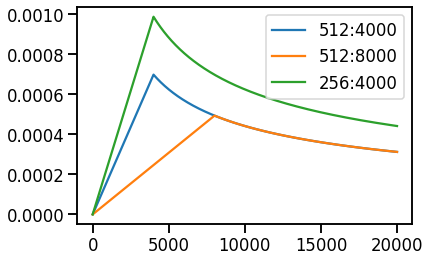

In [38]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

### Regularization

[(cite)](https://www.quantumdl.com/entry/11%EC%A3%BC%EC%B0%A82-Attention-is-All-You-Need-Transformer)

> 여기서 Label smoothing이란 target값에 대해 discrete한 값을 적용하는 것이 아닌 아주 작은 값을 이용해서 정답을 소수점으로 표현하고자 하는 방법이다. 이 모델에서는 정답에 대해 epsilon=0.1을 적용하고 있다. 이는 one-hot 분포(distribution)을 학습하는 대신 정답 단어에 대한 신뢰도(confidence)를 학습하려는 의도이다.

> Label smoothing은 정답에 대한 신뢰도가 너무 높게 예측될 경우 penalize하는 효과가 있다.

In [39]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


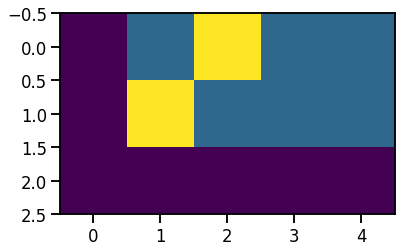

In [40]:
#Example
crit = LabelSmoothing(5, 0, 0.5)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


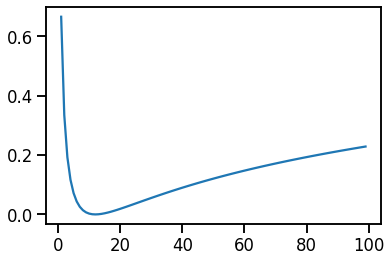

In [41]:
# Label smoothing starts to penalize the model 
# if it gets very confident about a given choice
crit = LabelSmoothing(5, 0, 0.2)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    '''
    Error Content: IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

    Pytorch 1.7.1에서 실행하면 오류가 발생한다.
    0.5 이전의 Pytorch와 0.5 이후의 Pytorch의 데이터 자료 구조가 바뀌었기 때문이다.
    Var.data[0]을 Var.data로 변경하면 해결된다.
    '''
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

## A First Example

### Synthetic Data

In [42]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

### Loss Computation

In [43]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data * norm #return loss.data[0] * norm

### Greedy Decoding

In [44]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch Step: 1 Loss: 3.676064 Tokens per Sec: 480.174988
Epoch Step: 1 Loss: 2.123384 Tokens per Sec: 720.261536
tensor(2.1804)
Epoch Step: 1 Loss: 2.223676 Tokens per Sec: 536.915649
Epoch Step: 1 Loss: 1.888655 Tokens per Sec: 736.019836
tensor(1.8768)
Epoch Step: 1 Loss: 2.038618 Tokens per Sec: 543.900574
Epoch Step: 1 Loss: 1.758216 Tokens per Sec: 723.921082
tensor(1.7578)
Epoch Step: 1 Loss: 2.140614 Tokens per Sec: 546.257751
Epoch Step: 1 Loss: 1.578303 Tokens per Sec: 757.106140
tensor(1.6335)
Epoch Step: 1 Loss: 1.752450 Tokens per Sec: 562.839417
Epoch Step: 1 Loss: 1.359030 Tokens per Sec: 747.850159
tensor(1.4750)
Epoch Step: 1 Loss: 1.576685 Tokens per Sec: 566.296204
Epoch Step: 1 Loss: 1.276485 Tokens per Sec: 737.702087
tensor(1.1911)
Epoch Step: 1 Loss: 1.310556 Tokens per Sec: 569.821411
Epoch Step: 1 Loss: 0.967039 Tokens per Sec: 742.203979
tensor(0.9725)
Epoch Step: 1 Loss: 1.039942 Tokens per Sec: 536.414246
Epoch Step: 1 Loss: 0.737766 Tokens per Sec: 747.096313

In [45]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[1, 5, 2, 3, 4, 7, 9, 8, 9, 8]])


## Train the Model

In [46]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
# https://nlp.seas.harvard.edu/2018/04/03/attention.html 의 모델을 구현하고, FULL Model 부분의 make_model 을 통해서 모델을 생성해주시면 됩니다.
pad_idx = TRG.vocab.stoi["<blank>"]
model = make_model(len(SRC.vocab), len(TRG.vocab), N=6)
model.to(dev)
#model_opt = get_std_opt(model). Not use.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=Fals

In [48]:
def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

In [49]:
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
criterion = LabelSmoothing(size=len(TRG.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.to(dev)
for epoch in range(3):
    model.train().to(dev)
    run_epoch((rebatch(pad_idx, b) for b in train_iterator), 
              model,
              SimpleLossCompute(model.generator, criterion, model_opt)).to(dev)
    model.eval().to(dev)
    loss = run_epoch((rebatch(pad_idx, b) for b in valid_iterator),
                     model,
                     SimpleLossCompute(model.generator, criterion, None)).to(dev)
    print(loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch Step: 1 Loss: 14.213741 Tokens per Sec: 139.744308
Epoch Step: 51 Loss: 9.475533 Tokens per Sec: 150.967651
Epoch Step: 101 Loss: 7.243104 Tokens per Sec: 147.933914
Epoch Step: 151 Loss: 5.027437 Tokens per Sec: 145.423630
Epoch Step: 201 Loss: 4.238389 Tokens per Sec: 146.214691
Epoch Step: 1 Loss: 3.859824 Tokens per Sec: 298.251068
tensor(4.0097)
Epoch Step: 1 Loss: 4.069856 Tokens per Sec: 128.587326
Epoch Step: 51 Loss: 3.762559 Tokens per Sec: 153.632080
Epoch Step: 101 Loss: 3.613672 Tokens per Sec: 153.000046
Epoch Step: 151 Loss: 3.361538 Tokens per Sec: 154.338104
Epoch Step: 201 Loss: 3.193061 Tokens per Sec: 150.192276
Epoch Step: 1 Loss: 2.689139 Tokens per Sec: 304.208618
tensor(2.8809)
Epoch Step: 1 Loss: 3.510982 Tokens per Sec: 144.689682
Epoch Step: 51 Loss: 2.888145 Tokens per Sec: 157.871964
Epoch Step: 101 Loss: 2.837568 Tokens per Sec: 152.734268
Epoch Step: 151 Loss: 2.587902 Tokens per Sec: 150.775146
Epoch Step: 201 Loss: 2.424860 Tokens per Sec: 151.742

### Translator Function

In [50]:
def translator(sent):
    model.eval()
    sent = sent.split()
    src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]]).to(dev)
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=100, start_symbol=TRG.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    trans = "<s> "
    for i in range(1, out.size(1)):
        sym = TRG.vocab.itos[out[0, i]]
        if sym == "</s>": break
        trans += sym + " "
    print(sent, '\n', trans)
    
    '''
    Add.
    '''
    return trans, sent

In [51]:
sent_ = 'eine feier in einer moschee mit vielen beobachtern, bei der ein mann spricht und ein anderer mann die gewänder anderer personen in ordnung bring, deren gesichter teilweise verborgen sind.'
trans, sent = translator(sent_)

Translation:	['eine', 'feier', 'in', 'einer', 'moschee', 'mit', 'vielen', 'beobachtern,', 'bei', 'der', 'ein', 'mann', 'spricht', 'und', 'ein', 'anderer', 'mann', 'die', 'gewänder', 'anderer', 'personen', 'in', 'ordnung', 'bring,', 'deren', 'gesichter', 'teilweise', 'verborgen', 'sind.'] 
 <s> in a room with many people are talking to a man and a man in the middle of a man is walking in the street . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


### Attention Visualization

Encoder Layer 2


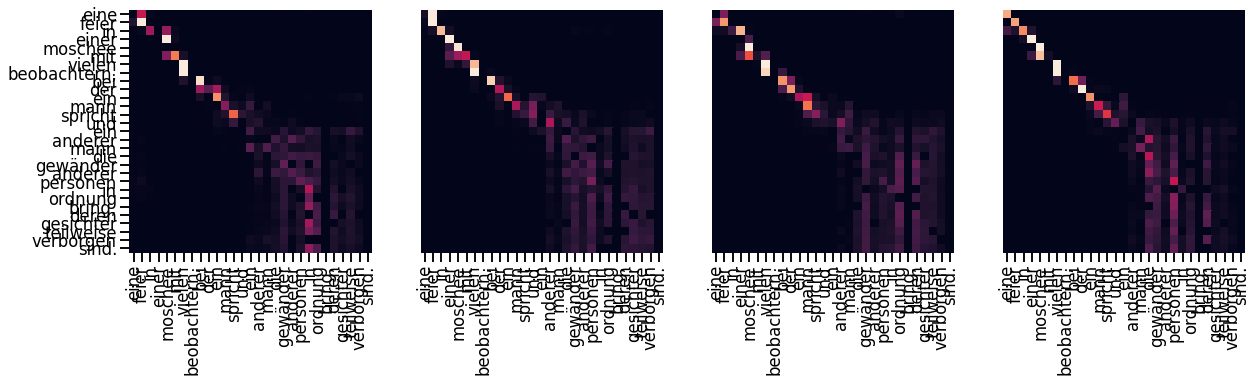

Encoder Layer 4


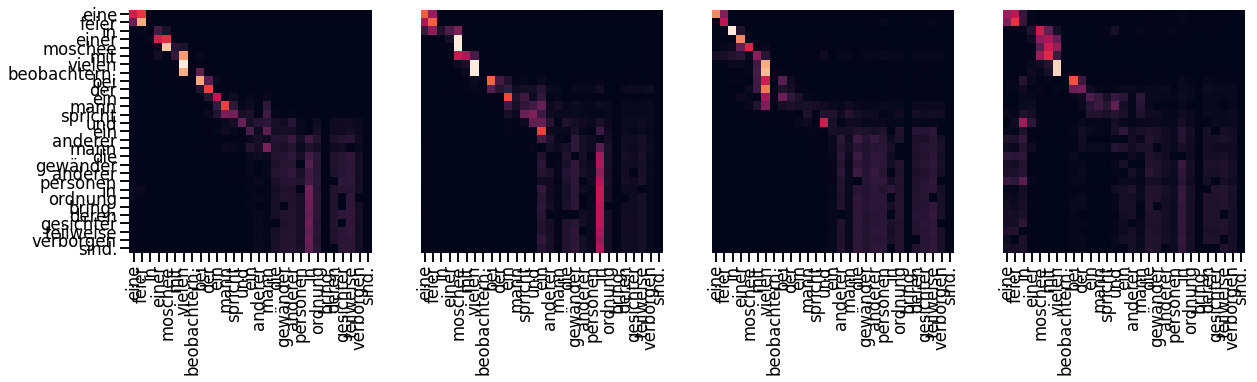

Encoder Layer 6


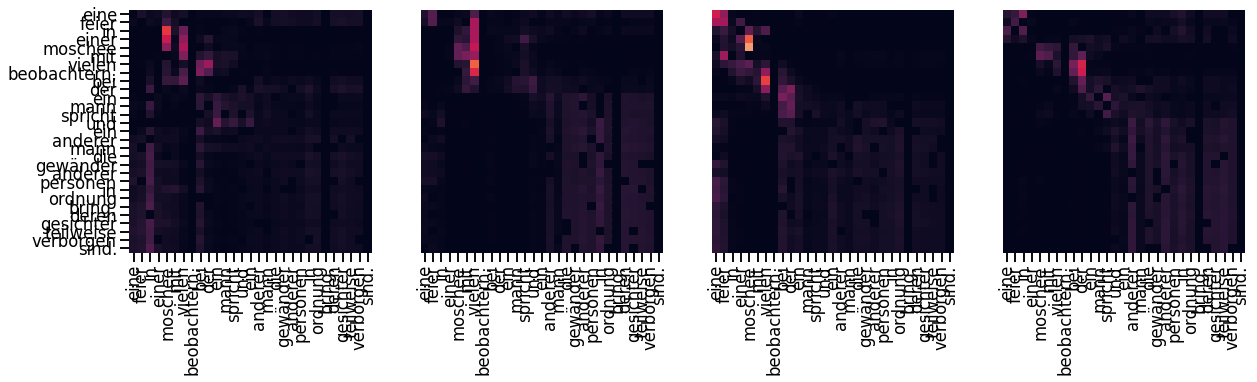

Decoder Self Layer 2


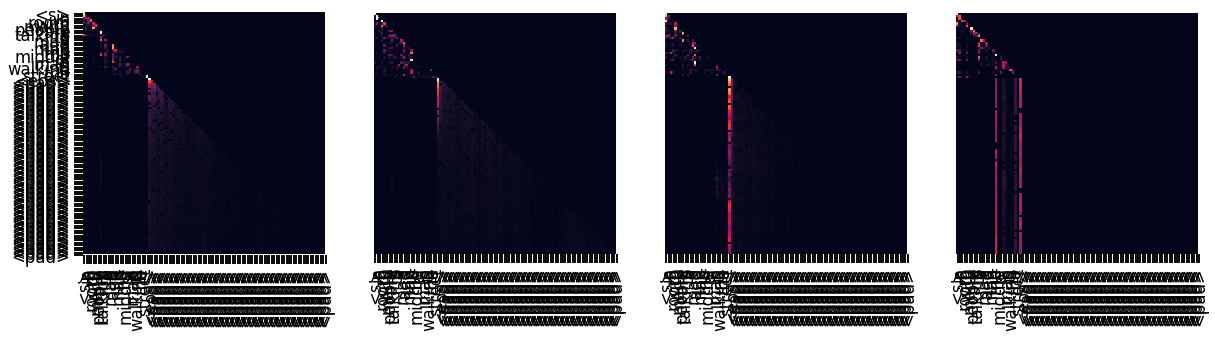

Decoder Src Layer 2


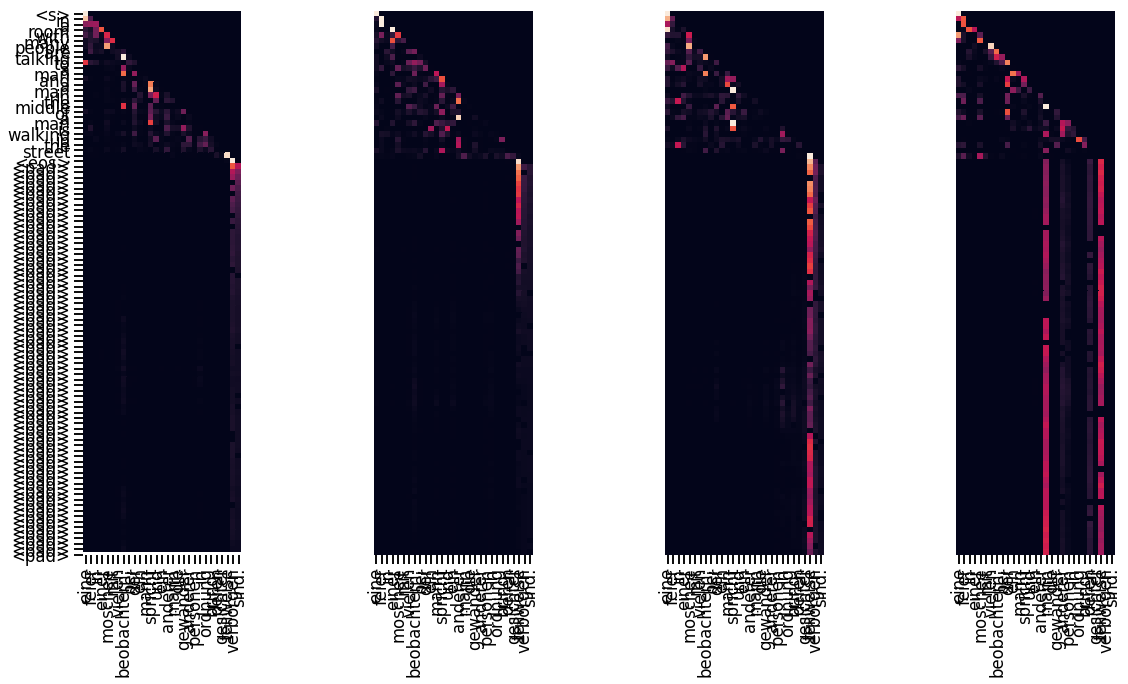

Decoder Self Layer 4


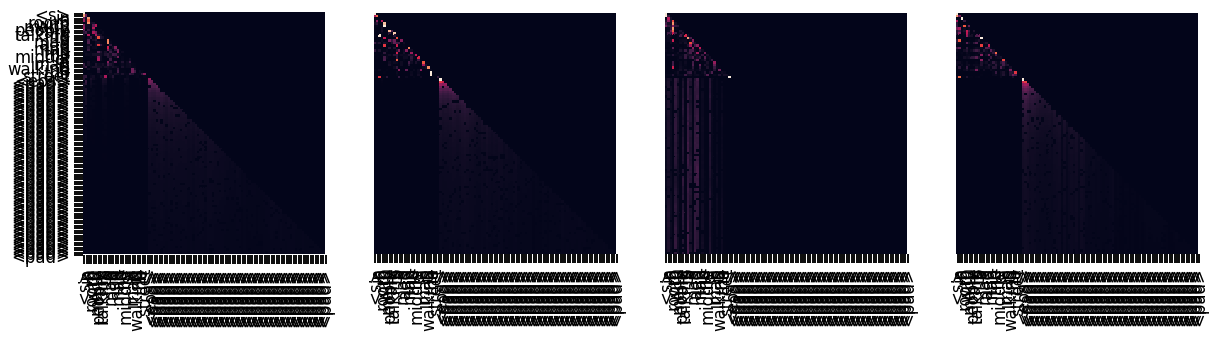

Decoder Src Layer 4


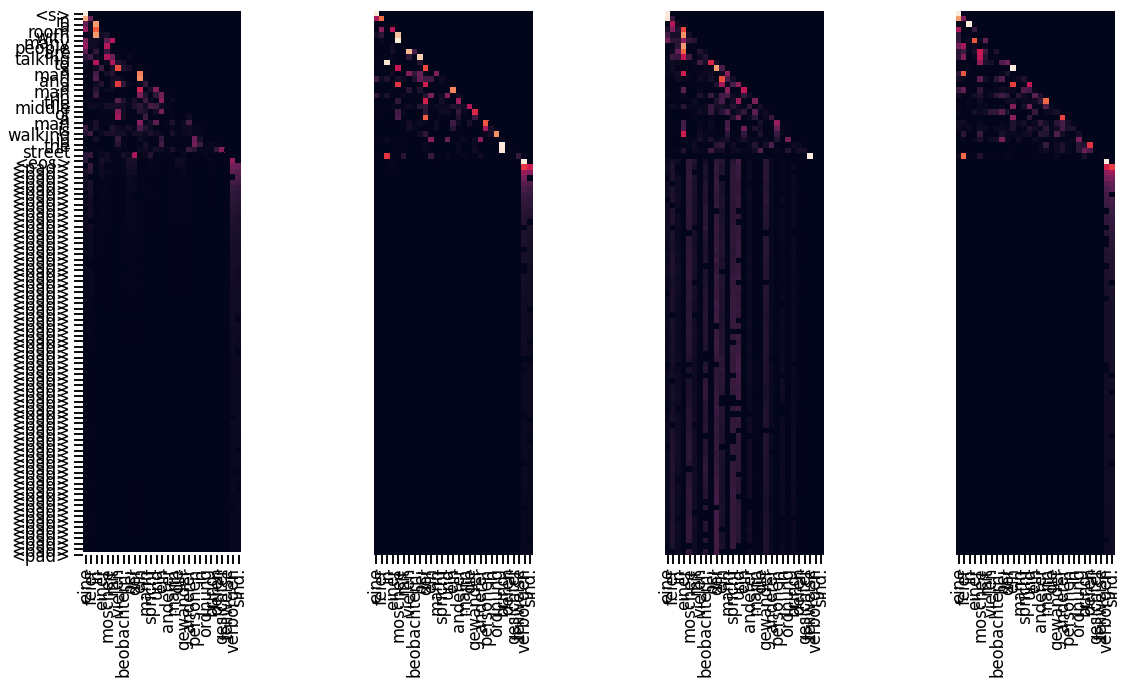

Decoder Self Layer 6


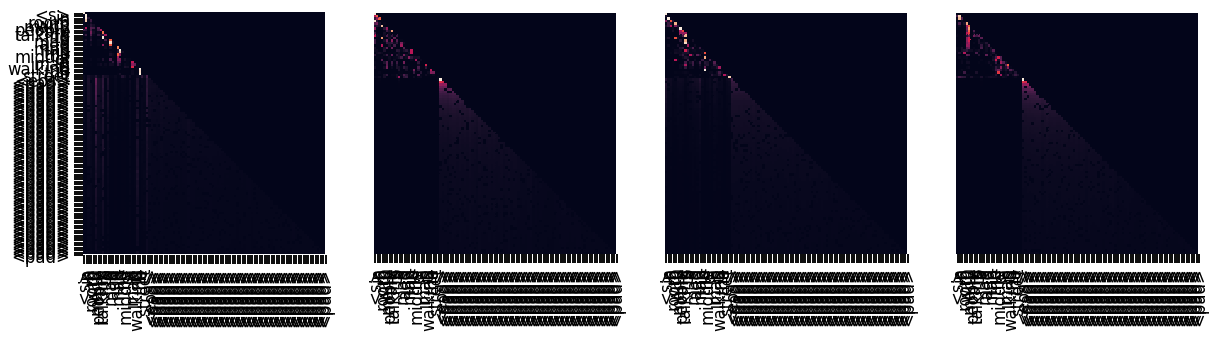

Decoder Src Layer 6


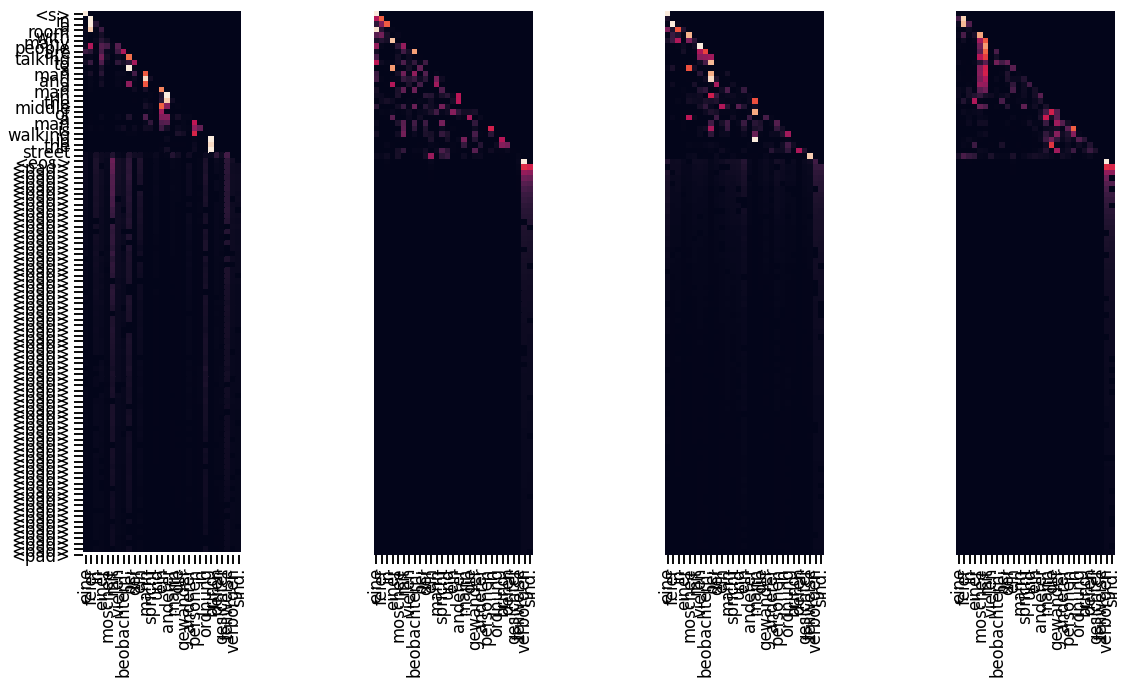

In [52]:
trg_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(trg_sent), :len(trg_sent)], 
            trg_sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(trg_sent), :len(sent)], 
            sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()

## Harvard NLP: A Real World Example

In [53]:
!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

--2021-01-16 15:29:18--  https://s3.amazonaws.com/opennmt-models/iwslt.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.104.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.104.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467317581 (446M) [application/x-www-form-urlencoded]
Saving to: ‘iwslt.pt.2’

iwslt.pt.2          100%[===================>] 445.67M  35.2MB/s    in 13s     

2021-01-16 15:29:32 (33.3 MB/s) - ‘iwslt.pt.2’ saved [467317581/467317581]



In [54]:
'''
Original Training the System.
'''

'''
if False:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model.train()
        run_epoch(train_iterator, 
                  model, 
                  SimpleLossCompute(model.generator, criterion, model_opt))
        model.eval()
        loss = run_epoch(train_iterator, 
                         model, 
                         SimpleLossCompute(model.generator, criterion, model_opt))
        print(loss)
else:
    model = torch.load("iwslt.pt", map_location=torch.device('cpu'))
'''

'\nif False:\n    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,\n            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))\n    for epoch in range(10):\n        model.train()\n        run_epoch(train_iterator, \n                  model, \n                  SimpleLossCompute(model.generator, criterion, model_opt))\n        model.eval()\n        loss = run_epoch(train_iterator, \n                         model, \n                         SimpleLossCompute(model.generator, criterion, model_opt))\n        print(loss)\nelse:\n    model = torch.load("iwslt.pt", map_location=torch.device(\'cpu\'))\n'

In [55]:
for i, batch in enumerate(valid_iterator):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TRG.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TRG.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TRG.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Translation:	man is working on a black horse . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Target:	a man cooking burgers on a black grill . <eos> <pad> <pad> 


In [56]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

--2021-01-16 15:29:35--  https://s3.amazonaws.com/opennmt-models/en-de-model.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.161.117
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.161.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393031182 (375M) [application/x-www-form-urlencoded]
Saving to: ‘en-de-model.pt.2’

en-de-model.pt.2    100%[===================>] 374.82M  35.2MB/s    in 11s     

2021-01-16 15:29:47 (33.4 MB/s) - ‘en-de-model.pt.2’ saved [393031182/393031182]



In [57]:
model, SRC, TRG = torch.load("en-de-model.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or se

In [ ]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]]).to(dev)
src = Variable(src)
src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TRG.vocab.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TRG.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)